<a href="https://colab.research.google.com/github/Darshansingh11/SMAI-FP/blob/main/Deconvolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [4]:
from torchvision.transforms import transforms
import cv2

In [ ]:
alex_net = models.alexnet(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
list(alex_net.features.children())[0].weight.shape

torch.Size([64, 3, 11, 11])

In [ ]:
list(alex_net.features.children())[0].weight.permute(0,1,3,2).shape

torch.Size([64, 3, 11, 11])

In [ ]:
def get_layers(alex_net):
    #alex_net = models.alexnet(pretrained=True)
    layers = list(alex_net.features.children())

    layer1 = nn.Sequential(*layers[:2], nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True))
    layer2 = nn.Sequential(*layers[3:6])
    layer3 = nn.Sequential(*layers[6:8])
    layer4 = nn.Sequential(*layers[8:10])
    layer5 = nn.Sequential(*layers[10:13])

    conv_layers = [layer1, layer2, layer3, layer4, layer5]

    conv1_t = nn.ConvTranspose2d(64, 3, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    conv2_t = nn.ConvTranspose2d(192, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    conv3_t = nn.ConvTranspose2d(384, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    conv4_t = nn.ConvTranspose2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    conv5_t = nn.ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    conv_t_layers = [conv1_t, conv2_t, conv3_t, conv4_t, conv5_t]

    conv_i = [0,3,6,8,10]
    with torch.no_grad():
        for i,conv_t in enumerate(conv_t_layers):
            conv_t.weight = nn.Parameter(layers[conv_i[i]].weight.permute(0,1,3,2))
            #conv_t.bias = nn.Parameter(layers[conv_i[i]].bias)

    return conv_layers, conv_t_layers

In [ ]:
conv_layers, conv_t_layers = get_layers(alex_net)

In [ ]:
img = torch.randn((1, 3, 256, 256))
img.shape

torch.Size([1, 3, 256, 256])

In [ ]:
out, pos = conv_layers[0](img)
out.shape

torch.Size([1, 64, 31, 31])

In [ ]:
pos.shape

torch.Size([1, 64, 31, 31])

In [ ]:
out[:,1,:,:].shape

torch.Size([1, 31, 31])

In [ ]:
unpool = nn.MaxUnpool2d(kernel_size=3, stride=2, padding=0)

In [ ]:
o = unpool(out, pos)
o.shape

torch.Size([1, 64, 63, 63])

In [ ]:
o = F.relu(o)

In [ ]:
o = conv_t_layers[0](o)
o.shape

torch.Size([1, 3, 255, 255])

In [ ]:
nn.ConvTranspose2d(64, 3, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)).weight.shape

torch.Size([64, 3, 11, 11])

In [ ]:
nn.ConvTranspose2d(64, 3, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)).bias.shape

torch.Size([3])

In [ ]:
!git clone https://github.com/huybery/VisualizingCNN.git

Cloning into 'VisualizingCNN'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 55 (delta 3), reused 3 (delta 3), pack-reused 47
Unpacking objects: 100% (55/55), done.


In [ ]:
%cd  /content/VisualizingCNN/

/content/VisualizingCNN


In [ ]:
!python main.py

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:02<00:00, 228MB/s]
Predicted: [('n02123045', 'tabby', 0.500922679901123), ('n02124075', 'Egyptian_cat', 0.28509995341300964), ('n02123159', 'tiger_cat', 0.2114189863204956)]
tensor(82.6285, grad_fn=<MaxBackward1>)
tensor(83.8370, grad_fn=<MaxBackwar

In [ ]:
list(alex_net.features.children())

[Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)]

In [ ]:
list(alex_net.classifier.children())

[Dropout(p=0.5, inplace=False),
 Linear(in_features=9216, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Linear(in_features=4096, out_features=1000, bias=True)]

In [2]:
class AlexNet(nn.Module):

    def __init__(self):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)), #0
            nn.ReLU(inplace=True), #1
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True), #2
            
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), #3
            nn.ReLU(inplace=True), #4
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True), #5
            
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #6
            nn.ReLU(inplace=True), #7
            
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #8
            nn.ReLU(inplace=True), #9
            
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #10
            nn.ReLU(inplace=True), #11
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True) #12
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=9216, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=1000, bias=True)
        )

        self.conv_i = [0,3,6,8,10]
        

        self.feature_maps = OrderedDict()
        self.switches = OrderedDict()
        self.init_weights()

    def init_weights(self):
    
        alexnet_pretrained = models.alexnet(pretrained=True)
        
        for idx, layer in enumerate(alexnet_pretrained.features):
            if isinstance(layer, nn.Conv2d):
                self.features[idx].weight.data = layer.weight.data
                self.features[idx].bias.data = layer.bias.data
        
        for idx, layer in enumerate(alexnet_pretrained.classifier):
            if isinstance(layer, nn.Linear):
                self.classifier[idx].weight.data = layer.weight.data
                self.classifier[idx].bias.data = layer.bias.data

    def forward(self, x):

        for idx, layer in enumerate(self.features):
            if isinstance(layer, nn.MaxPool2d):
                x, location = layer(x)
                # self.pool_locs[idx] = location
            else:
                x = layer(x)
        
        # reshape to (1, 512 * 7 * 7)
        x = x.view(x.size()[0], -1)
        output = self.classifier(x)
        return output


In [33]:
class AlexNetDeconv(nn.Module):

    def __init__(self):
        super(AlexNetDeconv, self).__init__()

        self.features = nn.Sequential(
            nn.MaxUnpool2d(kernel_size=3, stride=2, padding=0), #0
            nn.ReLU(inplace=True), #1
            nn.ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #2

            nn.ReLU(inplace=True), #3
            nn.ConvTranspose2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #4

            nn.ReLU(inplace=True), #5
            nn.ConvTranspose2d(384, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #6

            nn.MaxUnpool2d(kernel_size=3, stride=2, padding=0), #7
            nn.ReLU(inplace=True), #8
            nn.ConvTranspose2d(192, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), #9

            nn.MaxUnpool2d(kernel_size=3, stride=2, padding=0), #10
            nn.ReLU(inplace=True), #11
            nn.ConvTranspose2d(64, 3, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)) #12

        )

        self.layer_mapping = {5:0, 4:3, 3:5, 2:7, 1:10}

        self.unpool2pool_indices = {0:12, 7:5, 10:2}
        self.conv2deconv_indices = {0:12, 3:9, 6:6, 8:4, 10:2}

        self.init_weights()

    def init_weights(self):
        alexnet_pretrained = models.alexnet(pretrained=True)
        for idx, layer in enumerate(alexnet_pretrained.features):
            if isinstance(layer, nn.Conv2d):
                self.features[self.conv2deconv_indices[idx]].weight.data = layer.weight.data
                #self.features[self.conv2deconv_indices[idx]].bias.data\
                # = layer.bias.data

    def forward(self, x, layer, activation_idx, switches):
        # if layer in self.conv2deconv_indices:
        #     start_idx = self.conv2deconv_indices[layer]
        # else:
        #     raise ValueError('layer is not a conv feature map')
        start_idx = self.layer_mapping[layer]
        for idx in range(start_idx, len(self.features)):
            if isinstance(self.features[idx], nn.MaxUnpool2d):
                print(idx, x.shape,switches[self.unpool2pool_indices[idx]].shape)
                x = self.features[idx](x, switches[self.unpool2pool_indices[idx]])
            else:
                print(idx, x.shape)
                x = self.features[idx](x)
        return x
    

In [57]:
def load_images(img_path):

    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])
    
    img = transform(img)
    img.unsqueeze_(0)
    return img

In [6]:
def store(model):
    def hook(module, input, output, key):
        if isinstance(module, nn.MaxPool2d):
           model.feature_maps[key] = output[0]
           model.switches[key] = output[1]
        else:
           model.feature_maps[key] = output
    
    for idx, layer in enumerate(model._modules.get('features')):    
        # _modules returns an OrderedDict
        layer.register_forward_hook(partial(hook, key=idx))

In [19]:
def visualize_layer(layer_num, conv, deconv):
    layer_mapping = {5:12, 4:9, 3:7, 2:5, 1:2}
    layer = layer_mapping[layer_num]

    num_feat = conv.feature_maps[layer].shape[1]
    
    # set other feature map activations to zero
    new_feat_map = conv.feature_maps[layer].clone()

    # choose the max activations map
    act_lst = []
    for i in range(0, num_feat):
        choose_map = new_feat_map[0, i, :, :]
        activation = torch.max(choose_map)
        act_lst.append(activation.item())

    act_lst = np.array(act_lst)
    mark = np.argmax(act_lst)

    choose_map = new_feat_map[0, mark, :, :]
    max_activation = torch.max(choose_map)
    
    # make zeros for other feature maps
    if mark == 0:
        new_feat_map[:, 1:, :, :] = 0
    else:
        new_feat_map[:, :mark, :, :] = 0
        if mark != conv.feature_maps[layer].shape[1] - 1:
            new_feat_map[:, mark + 1:, :, :] = 0
    
    choose_map = torch.where(choose_map==max_activation,
            choose_map,
            torch.zeros(choose_map.shape)
            )

    # make zeros for ther activations
    new_feat_map[0, mark, :, :] = choose_map
    
    # print(torch.max(new_feat_map[0, mark, :, :]))    
    print(max_activation)
    print("input activation", new_feat_map.shape)
    deconv_output = deconv(new_feat_map, layer_num, mark, conv.switches)

    new_img = deconv_output.data.numpy()[0].transpose(1, 2, 0)  # (H, W, C)
    # normalize
    new_img = (new_img - new_img.min()) / (new_img.max() - new_img.min()) * 255
    new_img = new_img.astype(np.uint8)
    # cv2.imshow('reconstruction img ' + str(layer), new_img)
    # cv2.waitKey()
    return new_img, int(max_activation)

In [ ]:
a = torch.tensor([[1, 3],[6, 5]])

In [ ]:
torch.argmax(a, keepdim=True)

tensor([[2]])

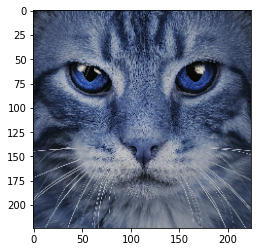

In [58]:
img = load_images('/content/cat.jpg')

In [34]:
conv = AlexNet()
conv.eval()
store(conv)

In [52]:
conv_out = conv(img)
switches = conv.switches

In [38]:
deconv = AlexNetDeconv()
deconv.eval()

AlexNetDeconv(
  (features): Sequential(
    (0): MaxUnpool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(384, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxUnpool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(192, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): MaxUnpool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  )
)

In [53]:
img, activation = visualize_layer(5, conv, deconv)

tensor(25.1274, grad_fn=<MaxBackward1>)
input activation torch.Size([1, 256, 6, 6])
0 torch.Size([1, 256, 6, 6]) torch.Size([1, 256, 6, 6])
1 torch.Size([1, 256, 13, 13])
2 torch.Size([1, 256, 13, 13])
3 torch.Size([1, 256, 13, 13])
4 torch.Size([1, 256, 13, 13])
5 torch.Size([1, 384, 13, 13])
6 torch.Size([1, 384, 13, 13])
7 torch.Size([1, 192, 13, 13]) torch.Size([1, 192, 13, 13])
8 torch.Size([1, 192, 27, 27])
9 torch.Size([1, 192, 27, 27])
10 torch.Size([1, 64, 27, 27]) torch.Size([1, 64, 27, 27])
11 torch.Size([1, 64, 55, 55])
12 torch.Size([1, 64, 55, 55])


In [40]:
for i in [2,5,12]:
    print(i, conv.switches[i].shape)

2 torch.Size([1, 64, 27, 27])
5 torch.Size([1, 192, 13, 13])
12 torch.Size([1, 256, 6, 6])


In [41]:
for i in range(13):
    print(i, conv.feature_maps[i].shape)

0 torch.Size([1, 64, 55, 55])
1 torch.Size([1, 64, 55, 55])
2 torch.Size([1, 64, 27, 27])
3 torch.Size([1, 192, 27, 27])
4 torch.Size([1, 192, 27, 27])
5 torch.Size([1, 192, 13, 13])
6 torch.Size([1, 384, 13, 13])
7 torch.Size([1, 384, 13, 13])
8 torch.Size([1, 256, 13, 13])
9 torch.Size([1, 256, 13, 13])
10 torch.Size([1, 256, 13, 13])
11 torch.Size([1, 256, 13, 13])
12 torch.Size([1, 256, 6, 6])


In [42]:
conv.switches[2].shape

torch.Size([1, 64, 27, 27])

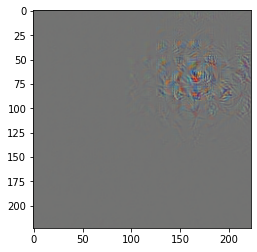

In [54]:
plt.imshow(img)